good intro ex of pm.Censored in PyMC: 
https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html

Terse example:
https://discourse.pymc.io/t/simple-exponential-survival-function/4961/8

McElreath Lecture:
https://www.youtube.com/watch?v=Zi6N3GLUJmw&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus&index=10

NB: The exponential distribution PDF and its CCDF look similar. The CCDF is the survival curve (P(T > t)). The PDF is the distribution of survival times (P(T = t)).

So re using an Exp(lam) for the expected survival time... I'm not sure how good it is? Playing around with https://homepage.divms.uiowa.edu/~mbognar/applets/exp-like.html , you see that the shape of Exp is the same for all lam, it's just over different scales. Maybe try a Gamma dist?

In [400]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.special import expit
import matplotlib.lines as mlines

In [401]:
RANDOM_SEED = 3
plt.rcParams['figure.constrained_layout.use'] = True

## Import

In [402]:
data = pd.read_csv("Horn_Crab Development Data for LOL_mod.csv", 
                   dtype={
                    # "C or T": "category"
                   },
                   converters={
                       "C or T": str.strip
                   })
data["C or T"] = data["C or T"].astype("category")

In [403]:
data.head()

,Crab #,C or T,Carapace Length,Carapace width,Collection Date,Death date,# of days alive,Enviro Plastics present Y/N,# of Yellow fibers ingested,# of days with viable eggs,Reach Larval Stage Y/N,# of stages,Egg Stage end of exp
0,1,c,16.04,12.54,8/4/18,10/14/18,71,N,0,21,y,1,8
1,2,c,21.30,17.15,8/4/18,10/14/18,71,N,0,71,y,5,3
2,3,c,17.13,12.00,8/4/18,10/14/18,71,N,0,24,y,4,5
3,4,c,25.49,19.22,8/4/18,10/14/18,71,N,0,71,y,4,4
4,5,c,15.02,12.46,8/4/18,10/14/18,71,N,0,24,y,10,8


In [404]:
data.dtypes

Crab #                            int64
C or T                         category
Carapace Length                 float64
Carapace width                  float64
Collection Date                  object
Death date                       object
# of days alive                   int64
Enviro Plastics present Y/N      object
# of Yellow fibers ingested       int64
# of days with viable eggs        int64
Reach Larval Stage Y/N           object
# of stages                       int64
Egg Stage end of exp              int64
dtype: object

In [405]:
data["C or T"].cat.codes

0     0
1     0
2     0
3     0
4     0
     ..
59    1
60    1
61    1
62    1
63    1
Length: 64, dtype: int8

In [406]:
data["C or T"].cat.codes.unique()

array([0, 1], dtype=int8)

death == 0 means crab was censored, so we know it survived at least 71 days,
so its probability is all of the probability density for your dist that is
above the censoring point, i.e. 1 - CDF(censoring pt, dist).
If your obs wasn't censored, you need to make sure its corresponding `upper` value is greater than it, so that it takes the PDF value at obs=x, and not the 1 - CDF value (ref: https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html). Here, I'm setting it to `np.Inf`.
c.f. https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html

IN THIS CASE, because all censoring happened at Tmax and no crab died at Tmax, I could've just set `upper=max(data["# of days alive"])`. All censored would've had that 1-CDF prob dens, and the dead would've had their regular old PDF. c.f. https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html

In [407]:
data["death"] = [0 if x == 71 else 1 for x in data["# of days alive"]]
data["c_or_t_grp"] = data["C or T"].cat.codes

data["upper"] = data.apply(
    lambda row: row["# of days alive"] if row["death"] == 0 else np.Inf, 
    axis=1)

In [408]:
data.head()

,Crab #,C or T,Carapace Length,Carapace width,Collection Date,Death date,# of days alive,Enviro Plastics present Y/N,# of Yellow fibers ingested,# of days with viable eggs,Reach Larval Stage Y/N,# of stages,Egg Stage end of exp,death,c_or_t_grp,upper
0,1,c,16.04,12.54,8/4/18,10/14/18,71,N,0,21,y,1,8,0,0,71.0
1,2,c,21.30,17.15,8/4/18,10/14/18,71,N,0,71,y,5,3,0,0,71.0
2,3,c,17.13,12.00,8/4/18,10/14/18,71,N,0,24,y,4,5,0,0,71.0
3,4,c,25.49,19.22,8/4/18,10/14/18,71,N,0,71,y,4,4,0,0,71.0
4,5,c,15.02,12.46,8/4/18,10/14/18,71,N,0,24,y,10,8,0,0,71.0


In [409]:
{x[0]: x[1] for x in data.loc[:, ["C or T", "c_or_t_grp"]].drop_duplicates().to_numpy()}

{'c': 0, 't': 1}

In [410]:
for i in range(10):
    print("i =", i, ",,, exp(i) =", int(np.exp(i)))

i = 0 ,,, exp(i) = 1
i = 1 ,,, exp(i) = 2
i = 2 ,,, exp(i) = 7
i = 3 ,,, exp(i) = 20
i = 4 ,,, exp(i) = 54
i = 5 ,,, exp(i) = 148
i = 6 ,,, exp(i) = 403
i = 7 ,,, exp(i) = 1096
i = 8 ,,, exp(i) = 2980
i = 9 ,,, exp(i) = 8103


## Model def

In [411]:
coords = {
    "grp": ["c", "t"],
}
PRIOR_MU = 5
with pm.Model(coords=coords) as model:
    # Data
    days_to_event_data = pm.ConstantData("days_to_event_data", data["# of days alive"])
    upper_data = pm.ConstantData("upper_data", data["upper"])
    grp_data = pm.ConstantData("grp_data", data["c_or_t_grp"])

    # Priors
    alpha = pm.Normal("alpha", mu=PRIOR_MU, sigma=1, dims="grp")
    mu = pm.Deterministic("mu", pm.math.exp(alpha[grp_data]))
    # lam = pm.Deterministic("lam", 1 / mu)

    # lik
    Y_obs = pm.Censored("Y_obs", 
                        dist=pm.Exponential.dist(scale=mu),
                        lower=None,
                        upper=upper_data,
                        observed=days_to_event_data)
    
    # derived vars
    diff = pm.Deterministic("control - treatment", pm.math.exp(alpha[0]) - pm.math.exp(alpha[1]))
    # this info is already in mu, but in mu it repeats for n obs times.
    exp_alpha = pm.Deterministic("exp_alpha", pm.math.exp(alpha), dims="grp")
    # log_diff = pm.Deterministic("log c-t", pm.math.log(diff))

## Checking the model before usage

### Graphviz
Does the model look right?

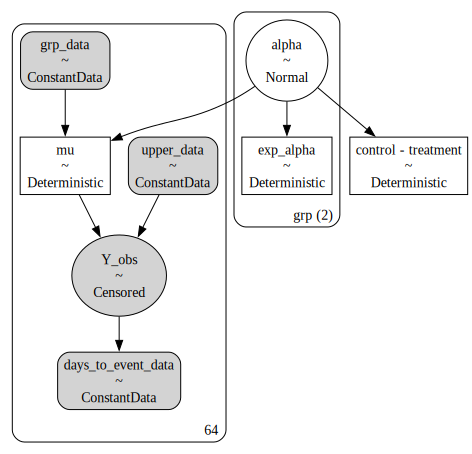

In [412]:
pm.model_to_graphviz(model)

### Prior

In [413]:
with model:
    idata_prior = pm.sample_prior_predictive()

Sampling: [Y_obs, alpha]


In [414]:
idata_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [415]:
c_alphas_prior = idata_prior.prior.exp_alpha[0,:100,0]
t_alphas_prior = idata_prior.prior.exp_alpha[0,:100,1]

In [416]:
c_alphas_prior_all = idata_prior.prior.exp_alpha[0,:,0]
t_alphas_prior_all = idata_prior.prior.exp_alpha[0,:,1]
c_alphas_prior_all.to_dataframe()["exp_alpha"].describe()
t_alphas_prior_all.to_dataframe()["exp_alpha"].describe()

count     500.000000
mean      229.975883
std       275.006609
min        11.947621
25%        73.861781
50%       146.274864
75%       284.002497
max      3056.003260
Name: exp_alpha, dtype: float64

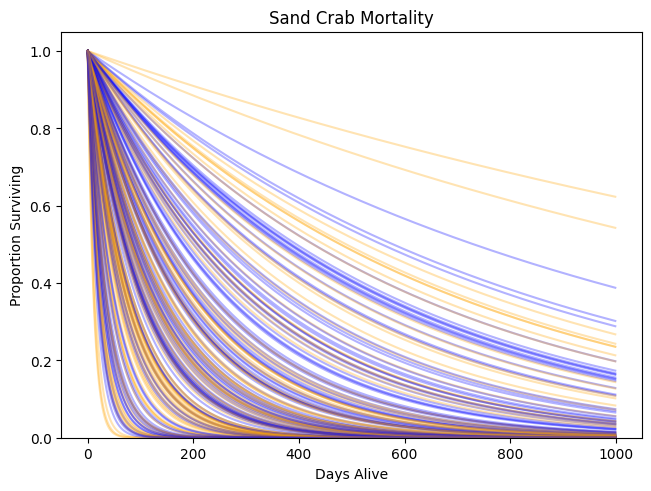

In [417]:
t = np.arange(1000).reshape((1, -1))
sample_curves_t = np.exp(-t / t_alphas_prior.to_numpy().reshape((-1, 1)))
sample_curves_c = np.exp(-t / c_alphas_prior.to_numpy().reshape((-1, 1)))

_, ax = plt.subplots()
ax.set_ylim(0, 1.05)

ax.set_title("Sand Crab Mortality")
ax.set_xlabel("Days Alive")
ax.set_ylabel("Proportion Surviving")

for i in range(sample_curves_t.shape[0]):
    t_artist = ax.plot(t.reshape(-1), 
                       sample_curves_t[i,:], 
                       color="blue", 
                       alpha=0.3)
    c_artist = ax.plot(t.reshape(-1), 
                       sample_curves_c[i,:], 
                       color="orange", 
                       alpha=0.3)

## Sampling

In [419]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Summaries, Plots

In [420]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

(0.0, 500.0)

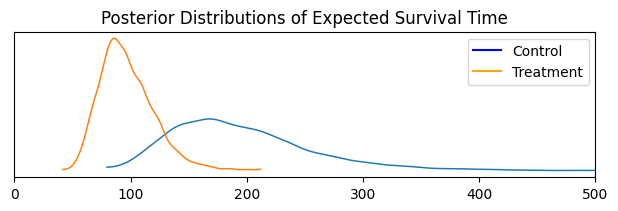

In [421]:
ax = az.plot_trace(idata,
            #   legend=True,
              combined=True,
              var_names=["alpha"], 
              transform=np.exp,
              
              kind="trace")

ax[0][1].set_visible(False)
ax[0][0].set_title("Posterior Distributions of Expected Survival Time")
blue_line = mlines.Line2D([], [], color='blue', label='Control')
orange_line = mlines.Line2D([], [], color='orange', label='Treatment')
ax[0][0].legend(handles=[blue_line, orange_line])
ax[0][0].set_xlim(0, 500)

Text(0.5, 0, 'Days Alive')

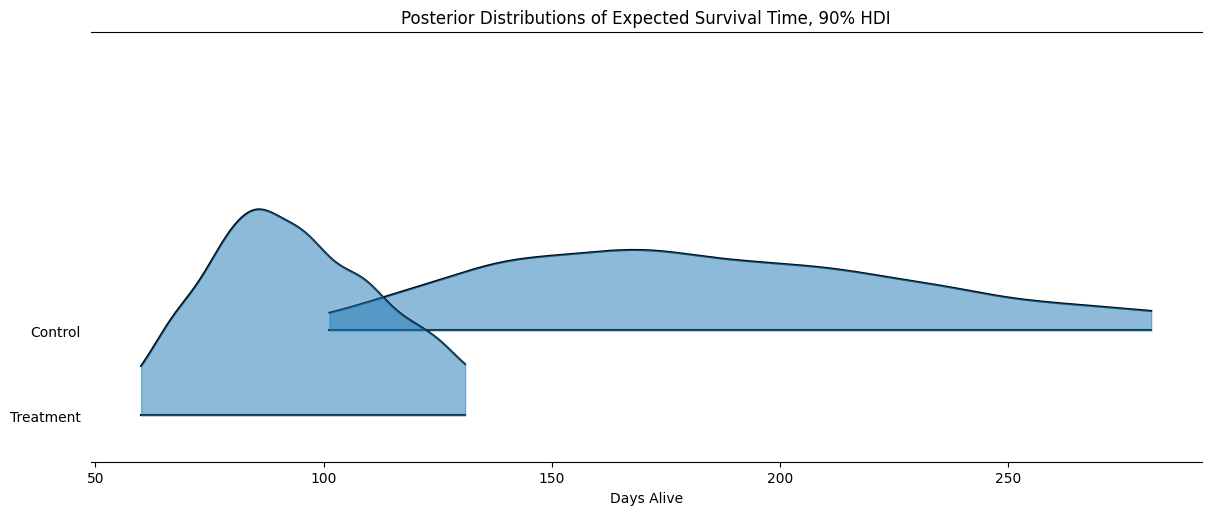

In [422]:
ax = az.plot_forest(idata,
               kind="ridgeplot",
               combined=True,
              var_names=["alpha"], 
              ridgeplot_alpha=0.5,
              hdi_prob=0.9,
              transform=np.exp)
ax[0].set_title("Posterior Distributions of Expected Survival Time, 90% HDI")
ax[0].set_yticklabels(["Treatment","Control"])
ax[0].set_xlabel("Days Alive")

Text(0.5, 0, 'Days Alive')

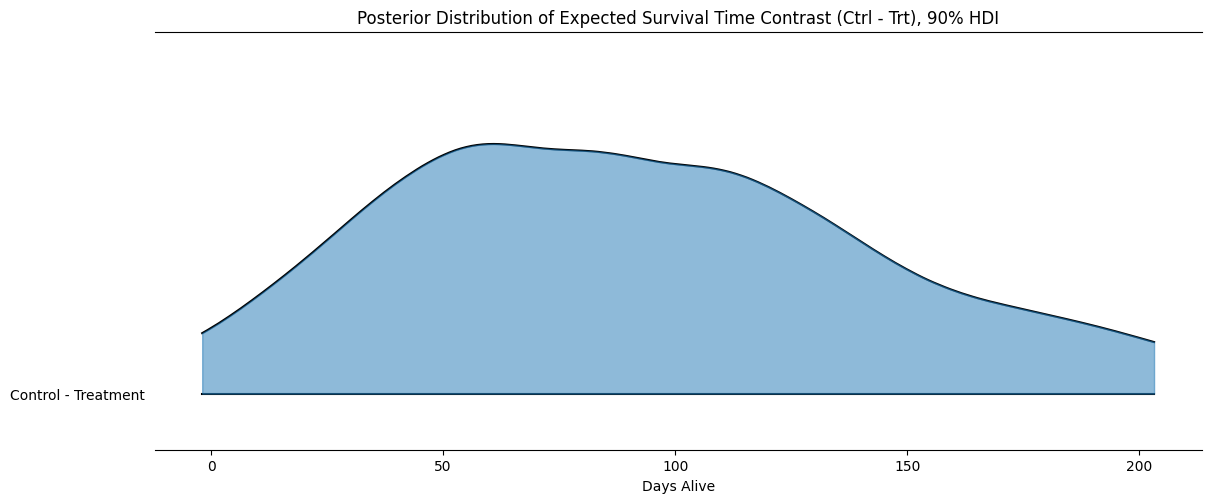

In [423]:
ax = az.plot_forest(idata,
               kind="ridgeplot",
               combined=True,
              var_names=["control - treatment"], 
              ridgeplot_alpha=0.5,
              hdi_prob=0.9)
ax[0].set_title("Posterior Distribution of Expected Survival Time Contrast (Ctrl - Trt), 90% HDI")
ax[0].set_yticklabels(["Control - Treatment"])
ax[0].set_xlabel("Days Alive")

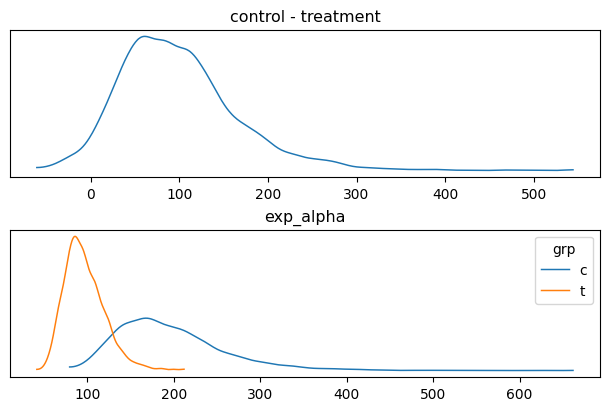

In [424]:
ax = az.plot_trace(idata,
              legend=True,
              combined=True,
              var_names=["control - treatment", "exp_alpha"], 
            #   transform=np.exp,
              kind="trace")

ax[0][1].set_visible(False)
ax[1][1].set_visible(False)

In [425]:
az.summary(idata, var_names=["alpha", "exp_alpha", "control - treatment"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[c],5.229,0.305,4.735,5.723,0.005,0.003,4065.0,2642.0,1.0
alpha[t],4.548,0.235,4.165,4.927,0.004,0.003,4293.0,2799.0,1.0
exp_alpha[c],195.747,63.807,100.299,282.408,1.062,0.802,4065.0,2642.0,1.0
exp_alpha[t],97.115,23.657,59.841,131.019,0.367,0.268,4293.0,2799.0,1.0
control - treatment,98.632,68.221,-2.126,203.223,1.116,0.909,4089.0,2619.0,1.0


In [426]:
# P(contrast > 0)
np.mean(idata.posterior["control - treatment"] > 0)

<xarray.DataArray 'control - treatment' ()> Size: 8B
array(0.9645)

array([<Axes: title={'center': 'exp_alpha\nc'}>,
       <Axes: title={'center': 'exp_alpha\nt'}>], dtype=object)

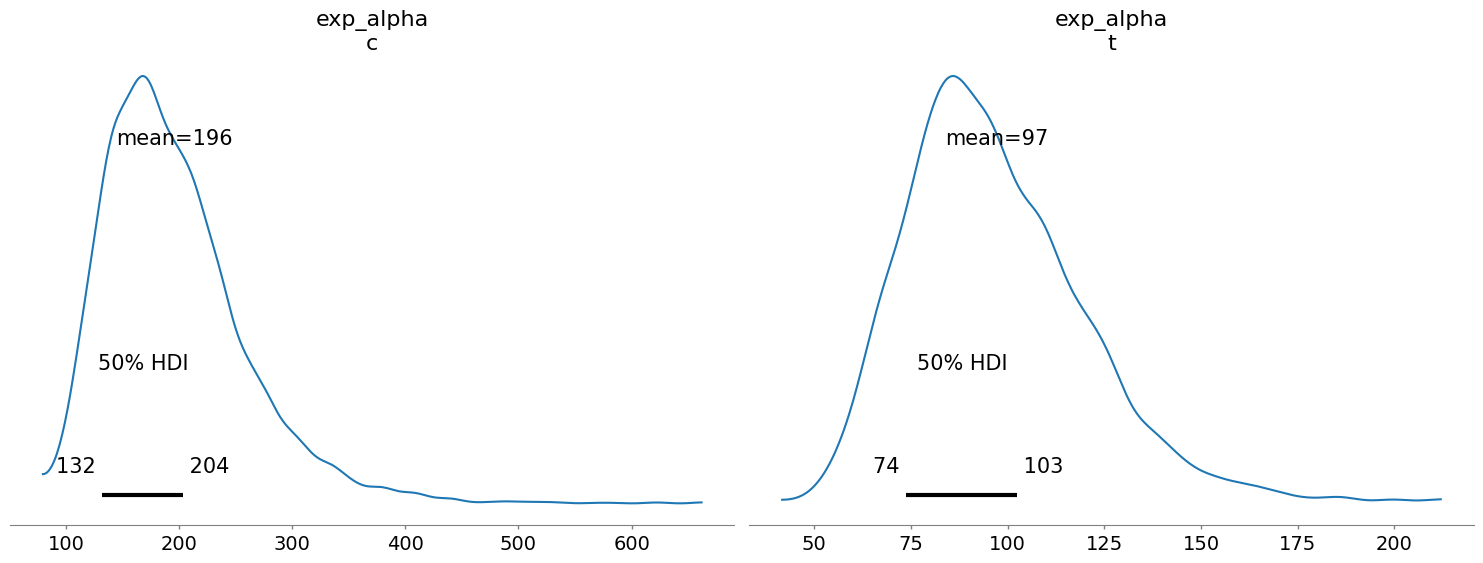

In [427]:
az.plot_posterior(idata, 
                  var_names=["exp_alpha"],
                  hdi_prob=0.5
                  )

## Survival Curves

Because we're assuming an Exponential distribution is an accurate representation of our survival, to model our survival curve, we plug our results for our alpha into the Exponential CCDF function. We use the CCDF because.. that's S(t), i.e. that's P(T > t) (c.f. ISLR).

Our alpha is just the log of mu, i.e. log of 1/lambda. c.f. Stat Rethinking lec 9, it's logged for priors' sake. mu is our expected time to event. CDF of Exp(mu) = 1 - exp(-x/mu), so CCDF = 1 - CDF = exp(-x/mu).

In [428]:
km_data = pd.read_csv("km_curve.csv")

In [429]:
km_data.head()

,pct_surv,time,grp
0,1.00000,0,c
1,0.96875,3,c
2,0.93750,9,c
3,0.90625,11,c
4,0.87500,15,c


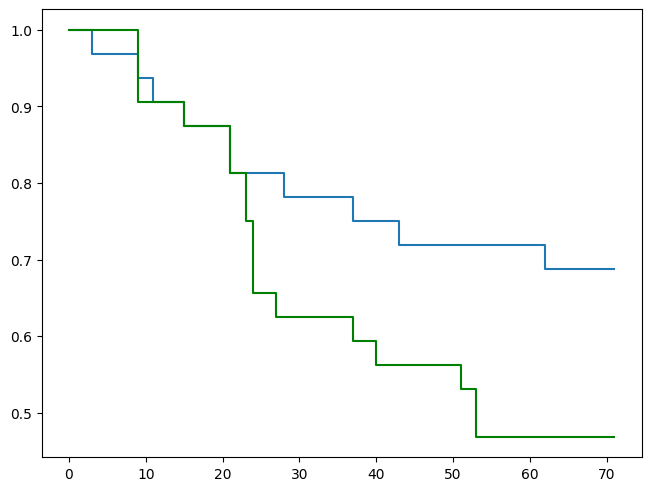

In [430]:
plt.step(x="time", 
         y="pct_surv",
         where="post", 
         data=km_data[km_data["grp"] == "c"])
plt.step(x="time", 
         y="pct_surv",
         where="post", 
         color="g",
         data=km_data[km_data["grp"] == "t"])

In [431]:
c_alphas = idata.posterior.exp_alpha[0,:100,0]
t_alphas = idata.posterior.exp_alpha[0,:100,1]

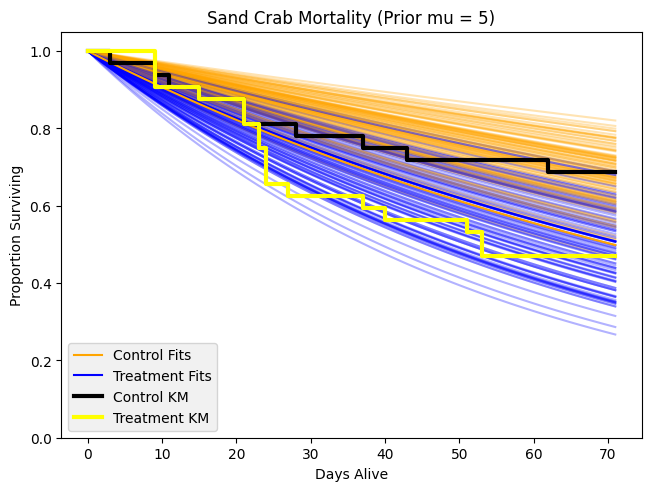

In [432]:
t = np.arange(72).reshape((1, -1))
sample_curves_t = np.exp(-t / t_alphas.to_numpy().reshape((-1, 1)))
sample_curves_c = np.exp(-t / c_alphas.to_numpy().reshape((-1, 1)))

_, ax = plt.subplots()
ax.set_ylim(0, 1.05)

ax.set_title(f"Sand Crab Mortality (Prior mu = {PRIOR_MU})")
ax.set_xlabel("Days Alive")
ax.set_ylabel("Proportion Surviving")

for i in range(sample_curves_t.shape[0]):
    t_artist = ax.plot(t.reshape(-1), 
                       sample_curves_t[i,:], 
                       color="blue", 
                       alpha=0.3)
    c_artist = ax.plot(t.reshape(-1), 
                       sample_curves_c[i,:], 
                       color="orange", 
                       alpha=0.3)

c_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="black",
         linewidth=3, 
         data=km_data[km_data["grp"] == "c"])

t_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="yellow",
         linewidth=3, 
         data=km_data[km_data["grp"] == "t"])

t_artist[0].set_alpha(1)
c_artist[0].set_alpha(1)
ax.legend([c_artist[0], t_artist[0], c_km_artist[0], t_km_artist[0]], 
          ["Control Fits", "Treatment Fits", "Control KM", "Treatment KM"],
          facecolor = "#eee")

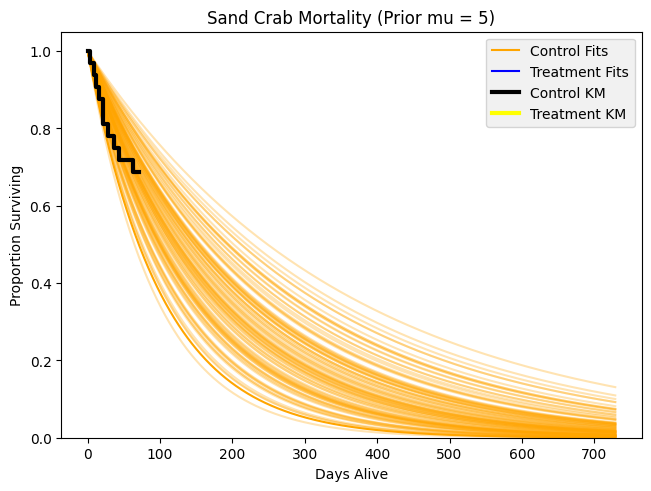

In [434]:
t = np.arange(730).reshape((1, -1))
sample_curves_t = np.exp(-t / t_alphas.to_numpy().reshape((-1, 1)))
sample_curves_c = np.exp(-t / c_alphas.to_numpy().reshape((-1, 1)))

_, ax = plt.subplots()
ax.set_ylim(0, 1.05)

ax.set_title(f"Sand Crab Mortality (Prior mu = {PRIOR_MU})")
ax.set_xlabel("Days Alive")
ax.set_ylabel("Proportion Surviving")

for i in range(sample_curves_t.shape[0]):
    # t_artist = ax.plot(t.reshape(-1), 
    #                    sample_curves_t[i,:], 
    #                    color="blue", 
    #                    alpha=0.3)
    c_artist = ax.plot(t.reshape(-1), 
                       sample_curves_c[i,:], 
                       color="orange", 
                       alpha=0.3)

c_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="black",
         linewidth=3, 
         data=km_data[km_data["grp"] == "c"])

# t_km_artist = ax.step(x="time", 
#          y="pct_surv",
#          where="post",
#          color="yellow",
#          linewidth=3, 
#          data=km_data[km_data["grp"] == "t"])

# t_artist[0].set_alpha(1)
c_artist[0].set_alpha(1)
ax.legend([c_artist[0], t_artist[0], c_km_artist[0], t_km_artist[0]], 
          ["Control Fits", "Treatment Fits", "Control KM", "Treatment KM"],
          facecolor = "#eee")

In [35]:
np.arange(101).reshape((-1, 1)).reshape(-1).shape

(101,)